# Using EOF analysis for noise reduction in your data
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/eof_noise_reduction.ipynb)


Demonstration of how to use EOF analysis to remove "noise" from your data set.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))


IN_COLAB = True


In [2]:
if IN_COLAB:
    !apt-get install libproj-dev proj-data proj-bin
    !apt-get install libgeos-dev
    !pip install cython
    !pip install cartopy
    !apt-get -qq install python-cartopy python3-cartopy
    !pip uninstall -y shapely    
    !pip install shapely --no-binary shapely  

    !pip install netcdf4 #Package for loading in netcdf4 files
    !pip install cmocean #Package with beautiful colormaps

import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.ma as ma
import numpy.linalg as LA
import matplotlib as mpl
import xarray as xr
import scipy

import cartopy as ct
import cartopy.crs as ccrs
import cmocean as cmocean

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-

In [3]:
mpl.rcParams['figure.dpi'] = 100
CL = 0.
mapProj = ct.crs.Robinson(central_longitude = CL)

### Globe plotting functions

In [4]:
def drawOnGlobe(ax, data, lats, lons, cmap='coolwarm', vmin=None, vmax=None, inc=None, cbarBool=True, contourMap=[], contourVals = [], fastBool=False, extent='both'):

    data_crs = ct.crs.PlateCarree()
    data_cyc, lons_cyc = add_cyclic_point(data, coord=lons) #fixes white line by adding point#data,lons#ct.util.add_cyclic_point(data, coord=lons) #fixes white line by adding point

    ax.set_global()
    ax.coastlines(linewidth = 1.2, color='black')
    if(fastBool):
        image = ax.pcolormesh(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    else:
        image = ax.pcolor(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    
    if(np.size(contourMap) !=0 ):
        contourMap_cyc, __ = add_cyclic_point(contourMap, coord=lons) #fixes white line by adding point
        ax.contour(lons_cyc,lats,contourMap_cyc,contourVals, transform=data_crs, colors='fuchsia')
    
    if(cbarBool):
        cb = plt.colorbar(image, shrink=.75, orientation="vertical", pad=.02, extend=extent)
        cb.ax.tick_params(labelsize=6) 
    else:
        cb = None

    image.set_clim(vmin,vmax)
    
    return cb, image  

def add_cyclic_point(data, coord=None, axis=-1):

    # had issues with cartopy finding utils so copied for myself
    
    if coord is not None:
        if coord.ndim != 1:
            raise ValueError('The coordinate must be 1-dimensional.')
        if len(coord) != data.shape[axis]:
            raise ValueError('The length of the coordinate does not match '
                             'the size of the corresponding dimension of '
                             'the data array: len(coord) = {}, '
                             'data.shape[{}] = {}.'.format(
                                 len(coord), axis, data.shape[axis]))
        delta_coord = np.diff(coord)
        if not np.allclose(delta_coord, delta_coord[0]):
            raise ValueError('The coordinate must be equally spaced.')
        new_coord = ma.concatenate((coord, coord[-1:] + delta_coord[0]))
    slicer = [slice(None)] * data.ndim
    try:
        slicer[axis] = slice(0, 1)
    except IndexError:
        raise ValueError('The specified axis does not correspond to an '
                         'array dimension.')
    new_data = ma.concatenate((data, data[tuple(slicer)]), axis=axis)
    if coord is None:
        return_value = new_data
    else:
        return_value = new_data, new_coord
    return return_value


### Data Description

2-meter monthly air temperature anomalies from the Berkeley Earth Surface Temperature (BEST) dataset. Below I sub-sample the data to only grab every fourth gridbox (to reduce the data size).

<xarray.Dataset>
Dimensions:      (latitude: 45, longitude: 90, month_number: 12, time: 708)
Coordinates:
  * time         (time) datetime64[ns] 1960-01-31 1960-02-29 ... 2018-12-31
  * longitude    (longitude) float32 -179.5 -175.5 -171.5 ... 168.5 172.5 176.5
  * latitude     (latitude) float32 -89.5 -85.5 -81.5 -77.5 ... 78.5 82.5 86.5
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    temperature  (time, latitude, longitude) float32 -2.435 -2.431 ... 2.578
    climatology  (month_number, latitude, longitude) float32 -27.5 ... -31.29
Attributes:
    CDI:                   Climate Data Interface version 1.9.2 (http://mpime...
    history:               Mon Mar 25 14:16:12 2019: cdo seldate,1950-01-01T0...
    institution:           Berkeley Earth Surface Temperature Project
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format

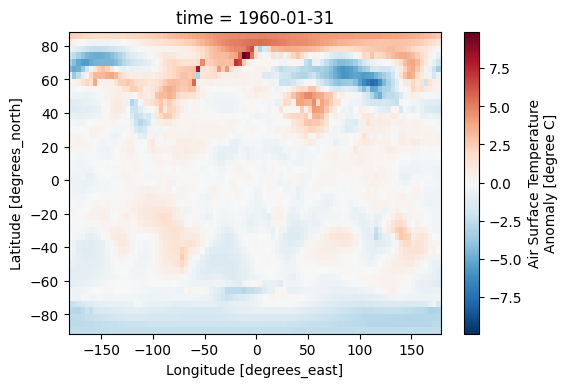

In [5]:
!pip install wget
import wget

if(IN_COLAB):
    # !wget https://github.com/eabarnes1010/ats655-coursematerial/raw/master/jupyter_notebooks/data/BEST-1950-2018-monthlyTemp.nc
    filename = wget.download('https://eabarnes-data.atmos.colostate.edu/course_objective_analysis/BEST-1950-2018-monthlyTemp.nc')    
    ds = xr.open_dataset(filename) # open the data
else:    
    ds = xr.open_dataset('../data/BEST-1950-2018-monthlyTemp.nc') # open the data

ds = ds.sel(time = slice('1960-01-01', '2020-01-01')) # only grab certain years
ds = ds[{'latitude': slice(None, None, 4), 'longitude': slice(None, None, 4)}] # downsample to make easier to manage
ds = ds.fillna(0.) # fill Nans with 0 for a zero anomaly
print(ds)

ds['temperature'][0].plot()

### Calculate the EOFs

In [6]:
# get data into a 2D matrix
X = ds['temperature'].values
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
X.shape

(708, 4050)

In [7]:
# calculate the covariance matrix in the spatial dimension
C = 1./np.size(X,axis = 0)*(np.dot(np.transpose(X),X))

# calculate eigenvalues and eigenvectors of C
lam, E = LA.eig(C)
Z = np.dot(X,E)

# convert eigenvalues to percent variance explained
pve = 100.*lam/np.sum(lam)


### User input

In [16]:
#========== MODIFY =============
eof_number = np.arange(0,10) #how many EOFs to retain, maximum = 4050 
month_to_plot = 100
#===============================

### Plot the results: eigenvalues

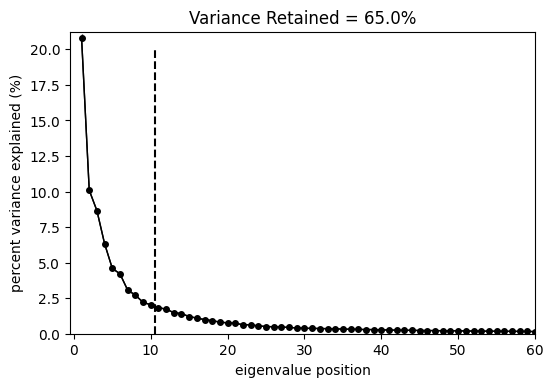

In [17]:
# plot results: EIGENVALUES
plt.figure()
plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 1, color = 'black', markersize = 4)

plt.plot([np.max(eof_number)+1.5,np.max(eof_number)+1.5],[0,20],'--k')
plt.title('Variance Retained = ' + str(np.round(np.sum(pve[eof_number]))) + '%')
plt.xlim(-0.5, np.max([60.,eof_number[-1]+1.5]))
plt.ylim(0,np.max(pve)*1.02)
plt.xlabel('eigenvalue position')
plt.ylabel('percent variance explained (%)')

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X,axis = 1)
eb = pve*np.sqrt(2./Nstar)
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black')

plt.show()

### Retain only the first few EOFs and reconstruct the data X

In [18]:
# reduce E and Z to the number of eofs you want to retain,
# then reconstruct X

# retain only certain eofs
Zrecon = np.copy(Z[:,eof_number])
Erecon = np.copy(E[:,eof_number])

# reconstruct X
Xrecon = np.dot(Zrecon,np.transpose(Erecon))

### Plot the results: compare the raw map and the smoothed map

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

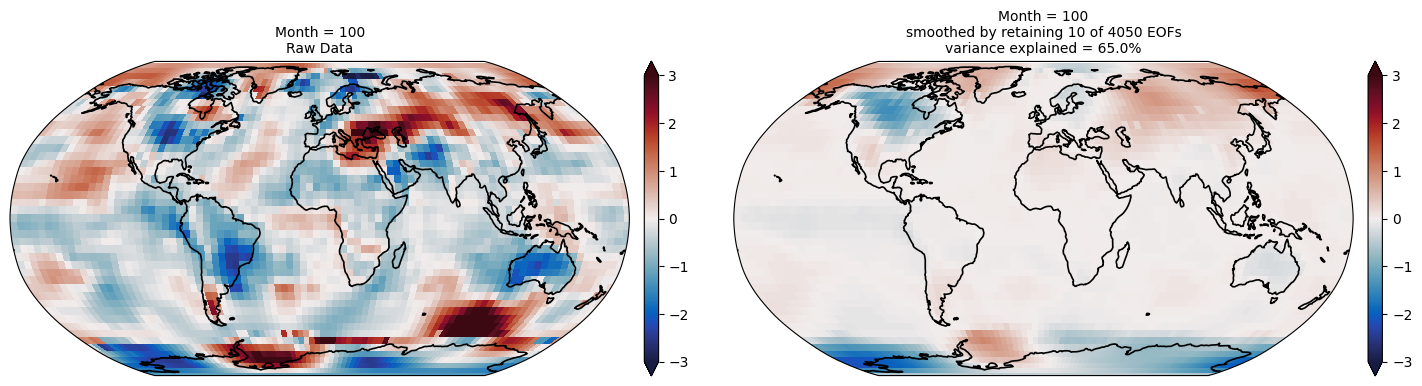

In [19]:
# plot the output
maxVal = 3.

titleSize = 10
cmap = cmocean.cm.balance
fastBool = True
lats = ds['latitude']
lons = ds['longitude']

plt.figure(figsize=(15,4.5))

ax = plt.subplot(1,2,1,projection=mapProj)
xplot = X.reshape(X.shape[0],len(lats),len(lons))[month_to_plot,:,:]
cb, image = drawOnGlobe(ax, xplot, lats, lons, cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
cb.set_label('', fontsize=titleSize)
cb.ax.tick_params(labelsize=titleSize) 
plt.title('Month = ' + str(month_to_plot) + '\nRaw Data', fontsize=titleSize)


ax = plt.subplot(1,2,2,projection=mapProj)
xplot = Xrecon.reshape(Xrecon.shape[0],len(lats),len(lons))[month_to_plot,:,:]
if(np.max(xplot.flatten())<1.):
    maxVal = np.max(xplot.flatten())
cb, image = drawOnGlobe(ax, xplot, lats, lons, cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
cb.set_label('', fontsize=titleSize)
cb.ax.tick_params(labelsize=titleSize) 
plt.title('Month = ' + str(month_to_plot) + '\nsmoothed by retaining ' + str(eof_number[-1]+1) + ' of ' + str(len(pve)) + ' EOFs' +
          '\nvariance explained = ' + str(np.round(np.sum(pve[eof_number]))) + '%', fontsize=titleSize)


plt.tight_layout()
plt.show()